In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
PATH = "\data"

train = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\train.csv"), parse_dates=["date"])
test = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\test.csv"), parse_dates=["date"])

oil = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\oil.csv"), parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\stores.csv"))
transaction = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\transactions.csv"), parse_dates=["date"])
holiday = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\holidays_events.csv"), parse_dates=["date"])

In [6]:
family_list = list(train.family.unique())
num_family = len(family_list)
store_list = train.store_nbr.unique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [9]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [10]:
print(f"the missing date are {missing_dates}, \nno seles on Christmas ")

the missing date are ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], 
no seles on Christmas 


מחשבה: בשביל מודל מדוייק אולי נכון להסתכל על המכירות יום לפני ויום אחרי החג, בפועל - אין בטסט נתונים מימי הכריסמס

### oil

no oil price at the weekends

In [7]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

print(num_missing_oil_dates,num_wknd_missing)

486 486


In [8]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [9]:
#3000888 rows before marege
print(len(train))
train = train.merge(oil, on = 'date', how='left')
print(len(train))


3000888
3000888


In [12]:
#28512 rows before marege
print(len(test))
test = test.merge(oil, on = 'date', how='left')
print(len(test))

28512
28512


## dates

In [10]:
train['week_day']=train.date.dt.day_of_week+1
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['year_day'] = train.date.dt.day_of_year
train['day_name'] = train.date.dt.day_name()
# 0: Winter - 1: Spring - 2: Summer - 3: Fall
train["season"] = np.where(train.month.isin([12,1,2]), 0, 1)
train["season"] = np.where(train.month.isin([6,7,8]), 2, train["season"])
train["season"] = pd.Series(np.where(train.month.isin([9, 10, 11]), 3, train["season"])).astype("int8")

In [14]:
train

,id,date,store_nbr,family,sales,onpromotion,oil,week_day,year,month,year_day,day_name,season
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,2,2013,1,1,Tuesday,0
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,2,2013,1,1,Tuesday,0
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,2,2013,1,1,Tuesday,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,2,2013,1,1,Tuesday,0
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,2,2013,1,1,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,2,2017,8,227,Tuesday,2
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,2,2017,8,227,Tuesday,2
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,2,2017,8,227,Tuesday,2
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,2,2017,8,227,Tuesday,2


In [15]:
temp =train.copy()

In [22]:
import plotly.express as px
temp = temp.groupby(["year", "week_day"]).sales.mean().reset_index()
px.line(temp, x="week_day", y="sales" , color = "year", title = "sales")

ניתן לראות שיש מחזוריות שבועית במכירות.

## holydays

צריך לשים לב שכשאנחנו מחברים את החגים אנחנו מחברים בצורה נכונה, כך שהחג יופיע רק עבור חנויות במדינות שחוגגות את אותו החג

In [15]:
holiday = pd.read_csv(os.path.join(r"C:\Users\yotam\Desktop\code\time_s\data\holidays_events.csv"), parse_dates=["date"])
holiday["date"] = pd.to_datetime(holiday.date)


אם אני מבין נכון, יש שני מקומות שבהם מצויים האם חג הועבר: עמודה ייעודית וב"סוג החג".

יש הבדל בין שני הסימונים. אם כתוב שחג הועבר בעמודה הייעודית - סימן שזה המועד האמיתי של החג, אבל הוא נדחה.
אם כתוב שחג נדחה ב"סוג החג", סימן שזה מועד שבו באמת מתקיים החג

for example, Independencia de Guayaquil	 is at 9.10. its transferd to ather day each year

In [18]:
print(len(holiday))
print(len(holiday[holiday.transferred==True]))

350
12


In [16]:
holiday.loc[holiday['transferred']==True,'type'] ='transferred-Holiday(original_day)'
holiday.drop(['transferred'],axis=1,inplace = True)

In [17]:
# Additional Holidays
holiday["description"] = holiday["description"]#.str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holiday["type"] = np.where(holiday["type"] == "Additional", "Holiday", holiday["type"])

# Bridge Holiday
holiday["description"] = holiday["description"].str.replace("Puente ", "")
holiday["description"] = holiday["description"].str.replace("Puente ", "")

holiday["type"] = np.where(holiday["type"] == "Bridge", "Holiday", holiday["type"])

In [18]:
holiday

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
345,2017-12-22,Holiday,National,Ecuador,Navidad-3
346,2017-12-23,Holiday,National,Ecuador,Navidad-2
347,2017-12-24,Holiday,National,Ecuador,Navidad-1
348,2017-12-25,Holiday,National,Ecuador,Navidad


In [19]:
work_day = holiday[holiday.type == "Work Day"]  
holiday = holiday[holiday.type != "Work Day"]  
events = holiday[holiday.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)



holiday = holiday[holiday.type != "Event"].drop("type", axis = 1)
regional = holiday[holiday.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holiday[holiday.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holiday[holiday.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()


In [20]:
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def my_one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = my_one_hot_encoder(events, nan_as_category=False)

events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)



In [21]:
national

,date,holiday_national
14,2012-08-10,Primer Grito de Independencia
19,2012-10-09,Independencia de Guayaquil
20,2012-10-12,Traslado Independencia de Guayaquil
21,2012-11-02,Dia de Difuntos
22,2012-11-03,Independencia de Cuenca
...,...,...
345,2017-12-22,Navidad-3
346,2017-12-23,Navidad-2
347,2017-12-24,Navidad-1
348,2017-12-25,Navidad


In [23]:
national.groupby(['date']).date.count()[national.groupby(['date']).date.count()>1]

date
2012-12-24    2
2012-12-31    2
2014-12-26    2
Name: date, dtype: int64

In [33]:
national[national['date']=='2014-12-26']

,date,holiday_national
156,2014-12-26,Navidad
157,2014-12-26,Navidad+1


In [34]:
national.drop(index=[35,39,156],inplace=True)

In [35]:
print(len(train))
df = pd.merge(train, store,how = "left", on = ["store_nbr"])
df["store_nbr"] = df["store_nbr"].astype("int8")
print(len(df))

df = pd.merge(df, national, how = "left",on = ["date"])
print(len(df))

3000888
3000888
3000888


In [38]:
# Regional
df = pd.merge(df, regional, how = "left", on = ["date", "state"])
print(len(df))

3000888


In [44]:
local.groupby(['date','city']).date.count()[local.groupby(['date','city']).date.count()>1]

date        city     
2016-07-24  Guayaquil    2
Name: date, dtype: int64

In [46]:
local[local['date']=='2016-07-24']

,date,city,holiday_local
264,2016-07-24,Guayaquil,Fundacion de Guayaquil-1
265,2016-07-24,Guayaquil,Traslado Fundacion de Guayaquil


In [50]:
local.drop(index=[265],inplace=True)

In [49]:
local[local['holiday_local'] == 'Fundacion de Guayaquil']

,date,city,holiday_local
65,2013-07-25,Guayaquil,Fundacion de Guayaquil
128,2014-07-25,Guayaquil,Fundacion de Guayaquil
183,2015-07-25,Guayaquil,Fundacion de Guayaquil
266,2016-07-25,Guayaquil,Fundacion de Guayaquil
322,2017-07-25,Guayaquil,Fundacion de Guayaquil


In [51]:
# Local
df = pd.merge(df, local, how = "left", on = ["date", "city"])
print(len(df))

3000888


In [54]:
df = pd.merge(df,work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")
print(len(df))

3000888


In [56]:
events.groupby(['date']).date.count()[events.groupby(['date']).date.count()>1]

date
2016-05-08    2
Name: date, dtype: int64

In [73]:
events[events['date']=='2016-05-08']
events.drop(index=[245],inplace=True)

In [75]:
df = pd.merge(df, events, how = "left")
df[events_cat] = df[events_cat].fillna(0)
print(len(df))

3000888


In [28]:


# Regional
df = pd.merge(df, regional, how = "left", on = ["date", "state"])
print(len(df))

# Local
df = pd.merge(df, local, how = "left", on = ["date", "city"])
print(len(df))
df = pd.merge(df,work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")
print(len(df))

df = pd.merge(df, events, how = "left")
df[events_cat] = df[events_cat].fillna(0)
print(len(df))


3000888
3000888
3002670
3002670
3002934
3002934
3004716


משהו בחיבור שעשיתי לא עובד טוב, נוספו שורות ויש איחודים מוזרים

In [76]:

# New features
df["holiday_national_binary"] = np.where(df.holiday_national.notnull(), 1, 0)
df["holiday_local_binary"] = np.where(df.holiday_local.notnull(), 1, 0)
df["holiday_regional_binary"] = np.where(df.holiday_regional.notnull(), 1, 0)

# 
df["national_independence"] = np.where(df.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
df["local_cantonizacio"] = np.where(df.holiday_local.str.contains("Cantonizacio"), 1, 0)
df["local_fundacion"] = np.where(df.holiday_local.str.contains("Fundacion"), 1, 0)
df["local_independencia"] = np.where(df.holiday_local.str.contains("Independencia"), 1, 0)




In [79]:
df.holiday_national_binary.mean() 

0.050475059382422804

In [27]:
#holidays, holidays_cat = one_hot_encoder(df[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
#df = pd.concat([df.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

#he_cols = df.columns[df.columns.str.startswith("events")].tolist() + df.columns[df.columns.str.startswith("holiday")].tolist() + df.columns[df.columns.str.startswith("national")].tolist()+ df.columns[df.columns.str.startswith("local")].tolist()
#df[he_cols] = df[he_cols].astype("int8")

#d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

#del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
#gc.collect()

#df.head(10)

In [28]:
citys = list(store['city'].unique())

In [29]:
locales = list(holiday['locale_name'].unique())

In [30]:
city_only = []
local_only = []
for city in citys:
    if city not in locales:
        city_only.append(city)
for locl in locales:
    if locl not in citys:
        local_only.append(locl)

יש כמה ערים שאין להם חג ייעודי, וכמה חגים מקומיים שלא שייכים לאף מקום

ראיתי שבהרבה מחברות "מאחדים" בין סוגי החגים השונים, אני לא בטוח שזה נכון. יש מצב שביום החג עצמו עושים ארוחה משפחתית ללא תלות בהגדרה של החג (למשל), בנוסף המועד האמיתי של החג יכול להשפיע על 
סוגיות של אספקה

צריך לעשות בדיקה אל מול הנתונים

ביקשתי מצאט גיפיטי לייצר לי רשימה עם חגים שרלוונטיים לכל מדינה ולכל עיר. אחרי זה אני אאחד את הרשימות כך שלכל עיר יופיע גם אלו של המדינה שלה, ואז אם החג הוא לוקאלי - ניתן אותו רק למי שרלוונטי

In [31]:
state_holidays_dict ={
    'Pichincha': [
        'Fundacion de Quito', 'Fundacion de Quito-1', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Fundacion de Quito',
        'Mundial de futbol Brasil: Ecuador-Suiza', 'Mundial de futbol Brasil: Ecuador-Honduras',
        'Mundial de futbol Brasil: Ecuador-Francia', 'Mundial de futbol Brasil: Octavos de Final',
        'Mundial de futbol Brasil: Cuartos de Final', 'Mundial de futbol Brasil: Semifinales',
        'Mundial de futbol Brasil: Tercer y cuarto lugar', 'Mundial de futbol Brasil: Final',
        'Navidad-4', 'Navidad-3', 'Navidad-2', 'Puente Navidad', 'Navidad-1', 'Navidad', 'Navidad+1'
    ],
    'Santo Domingo de los Tsachilas': [
        'Fundacion de Santo Domingo', 'Provincializacion de Santo Domingo',
        'Traslado Fundacion de Santo Domingo'
    ],
    'Cotopaxi': [
        'Provincializacion de Cotopaxi', 'Cantonizacion de Latacunga', 'Independencia de Latacunga',
        'Puente Dia de Difuntos', 'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Chimborazo': [
        'Cantonizacion de Riobamba', 'Fundacion de Riobamba', 'Independencia de Ambato',
        'Traslado Batalla de Pichincha', 'Traslado Fundacion de Guayaquil',
        'Traslado Primer Grito de Independencia'
    ],
    'Imbabura': [
        'Provincializacion de Imbabura', 'Cantonizacion de Ibarra', 'Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Bolivar': [
        'Cantonizacion de Guaranda', 'Independencia de Guaranda'
    ],
    'Pastaza': [
        'Cantonizacion del Puyo'
    ],
    'Tungurahua': [
        'Fundacion de Ambato', 'Independencia de Ambato', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Guayas': [
        'Fundacion de Guayaquil', 'Cantonizacion de Libertad', 'Cantonizacion de El Carmen',
        'Cantonizacion de Quevedo', 'Independencia de Guayaquil', 'Traslado Independencia de Guayaquil',
        'Navidad-4', 'Navidad-3', 'Navidad-2', 'Puente Navidad', 'Navidad-1', 'Navidad', 'Navidad+1'
    ],
    'Santa Elena': [
        'Provincializacion Santa Elena', 'Cantonizacion de Salinas', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Los Rios': [
        'Cantonizacion de Quevedo', 'Dia de la Madre'
    ],
    'Azuay': [
        'Independencia de Cuenca', 'Dia de la Madre-1'
    ],
    'Loja': [
        'Fundacion de Loja', 'Dia de la Madre'
    ],
    'El Oro': [
        'Fundacion de Machala', 'Puente Primer dia del ano', 'Traslado Primer dia del ano'
    ],
    'Esmeraldas': [
        'Fundacion de Esmeraldas'
    ],
    'Manabi': [
        'Cantonizacion de Manta', 'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
        'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5', 'Terremoto Manabi+6',
        'Terremoto Manabi+7', 'Terremoto Manabi+8', 'Terremoto Manabi+9', 'Terremoto Manabi+10',
        'Terremoto Manabi+11', 'Terremoto Manabi+12', 'Terremoto Manabi+13', 'Terremoto Manabi+14',
        'Terremoto Manabi+15', 'Terremoto Manabi+16', 'Terremoto Manabi+17', 'Terremoto Manabi+18',
        'Terremoto Manabi+19', 'Terremoto Manabi+20', 'Terremoto Manabi+21', 'Terremoto Manabi+22',
        'Terremoto Manabi+23', 'Terremoto Manabi+24', 'Terremoto Manabi+25', 'Terremoto Manabi+26',
        'Terremoto Manabi+27', 'Terremoto Manabi+28', 'Terremoto Manabi+29', 'Terremoto Manabi+30'
    ]
}
city_holiday_dict = {
    'Quito': [
        'Fundacion de Quito', 'Fundacion de Quito-1', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Fundacion de Quito',
        'Dia de la Madre-1', 'Dia de la Madre', 'Dia de Difuntos', 'Recupero Puente Dia de Difuntos',
        'Traslado Primer dia del ano', 'Black Friday', 'Recupero Puente Primer dia del ano'
    ],
    'Santo Domingo': [
        'Fundacion de Santo Domingo', 'Provincializacion de Santo Domingo',
        'Traslado Fundacion de Santo Domingo'
    ],
    'Cayambe': [
        'Cantonizacion de Cayambe'
    ],
    'Latacunga': [
        'Cantonizacion de Latacunga', 'Independencia de Latacunga',
        'Puente Dia de Difuntos', 'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Riobamba': [
        'Cantonizacion de Riobamba', 'Fundacion de Riobamba',
        'Independencia de Ambato', 'Traslado Batalla de Pichincha',
        'Traslado Fundacion de Guayaquil', 'Traslado Primer Grito de Independencia'
    ],
    'Ibarra': [
        'Cantonizacion de Quevedo', 'Provincializacion de Imbabura', 'Cantonizacion de Ibarra',
        'Dia de Difuntos', 'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Guaranda': [
        'Cantonizacion de Guaranda', 'Independencia de Guaranda'
    ],
    'Puyo': [
        'Cantonizacion del Puyo'
    ],
    'Ambato': [
        'Fundacion de Ambato', 'Independencia de Ambato', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Guayaquil': [
        'Fundacion de Guayaquil', 'Cantonizacion de Libertad', 'Cantonizacion de El Carmen',
        'Cantonizacion de Quevedo', 'Independencia de Guayaquil', 'Traslado Independencia de Guayaquil',
        'Dia de la Madre', 'Puente Dia de Difuntos', 'Recupero Puente Dia de Difuntos',
        'Traslado Primer dia del ano', 'Cyber Monday', 'Recupero Puente Primer dia del ano'
    ],
    'Salinas': [
        'Cantonizacion de Salinas', 'Puente Dia de Difuntos',
        'Recupero Puente Dia de Difuntos', 'Traslado Primer dia del ano'
    ],
    'Daule': [
        'Dia del Trabajo'
    ],
    'Babahoyo': [
        'Dia de la Madre'
    ],
    'Quevedo': [
        'Cantonizacion de Quevedo', 'Dia del Trabajo', 'Dia de la Madre'
    ],
    'Playas': [
        'Dia de la Madre'
    ],
    'Libertad': [
        'Cantonizacion de Libertad', 'Dia de la Madre'
    ],
    'Cuenca': [
        'Independencia de Cuenca', 'Dia de la Madre-1'
    ],
    'Loja': [
        'Fundacion de Loja', 'Dia de la Madre'
    ],
    'Machala': [
        'Fundacion de Machala', 'Puente Primer dia del ano', 'Traslado Primer dia del ano'
    ],
    'Esmeraldas': [
        'Fundacion de Esmeraldas'
    ],
    'Manta': [
        'Cantonizacion de Manta', 'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
        'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5', 'Terremoto Manabi+6',
        'Terremoto Manabi+7', 'Terremoto Manabi+8', 'Terremoto Manabi+9', 'Terremoto Manabi+10',
        'Terremoto Manabi+11', 'Terremoto Manabi+12', 'Terremoto Manabi+13', 'Terremoto Manabi+14',
        'Terremoto Manabi+15', 'Terremoto Manabi+16', 'Terremoto Manabi+17', 'Terremoto Manabi+18',
        'Terremoto Manabi+19', 'Terremoto Manabi+20', 'Terremoto Manabi+21', 'Terremoto Manabi+22',
        'Terremoto Manabi+23', 'Terremoto Manabi+24', 'Terremoto Manabi+25', 'Terremoto Manabi+26',
        'Terremoto Manabi+27', 'Terremoto Manabi+28', 'Terremoto Manabi+29', 'Terremoto Manabi+30'
    ],
    'El Carmen': [
        'Cantonizacion de El Carmen'
    ]
}


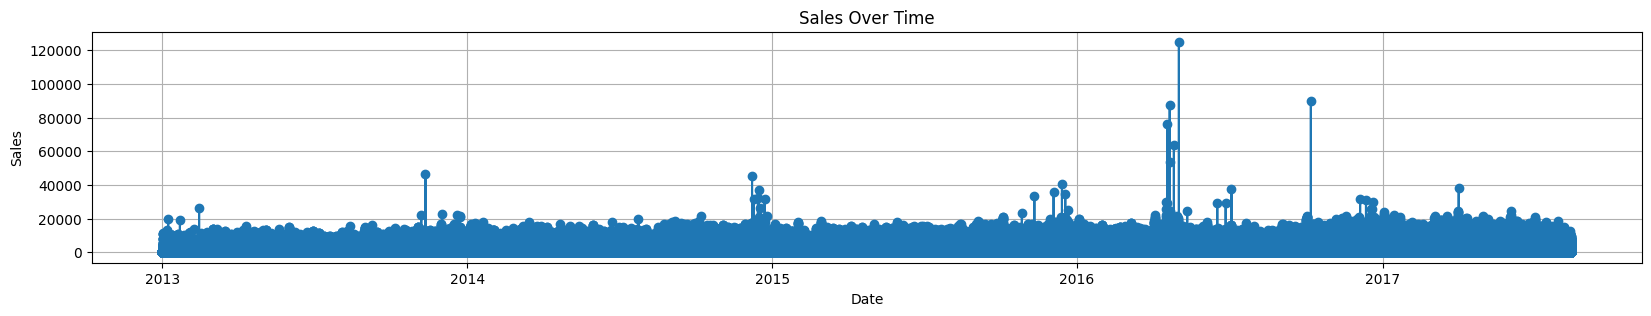

In [32]:
plt.figure(figsize=(20, 3))
plt.plot(train['date'], train['sales'], marker='o', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

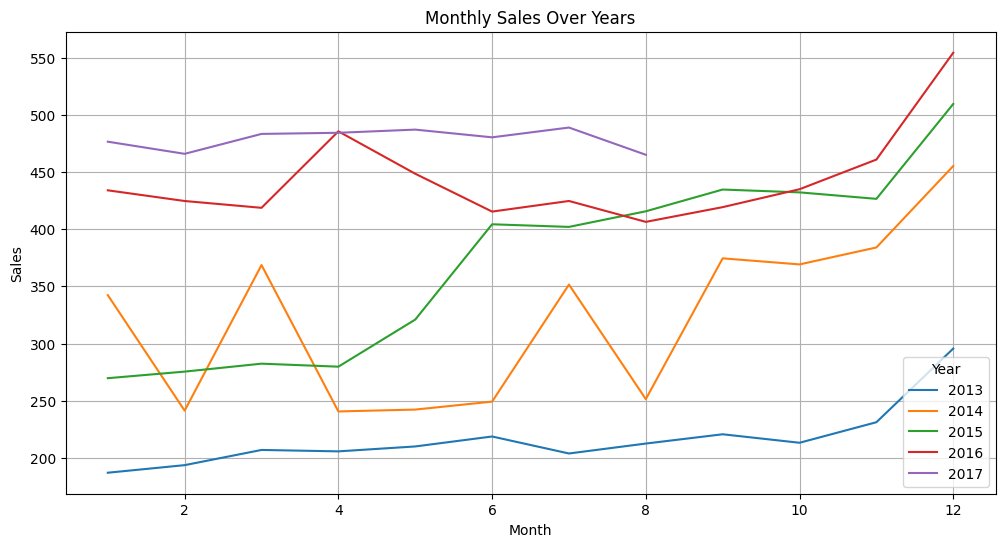

In [33]:
sales_by_month = train.groupby(['year', 'month'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot each year's sales as a separate line with a different color
for year in sales_by_month['year'].unique():
    year_data = sales_by_month[sales_by_month['year'] == year]
    sns.lineplot(data=year_data, x='month', y='sales', label=year)

plt.title('Monthly Sales Over Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



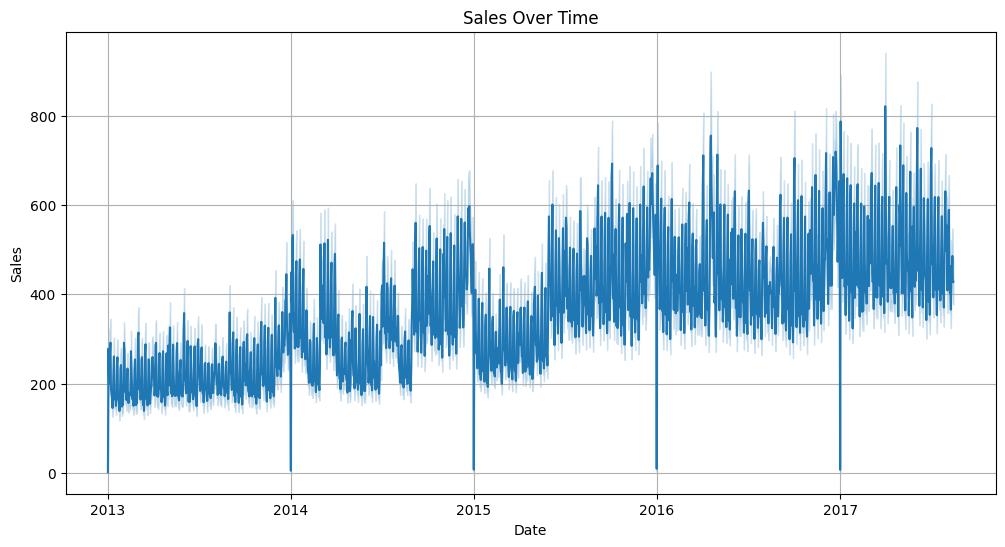

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x='date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

נראה שיש עונתיות שנתית מסוימת

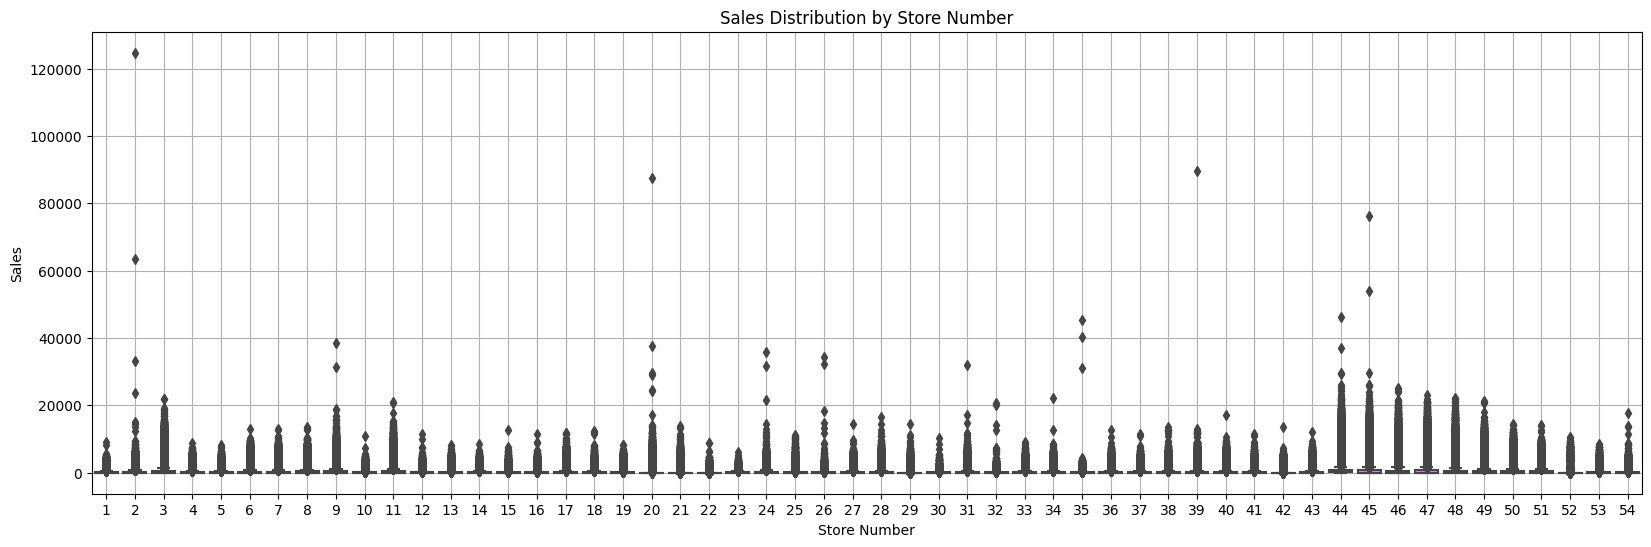

In [35]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=train, x='store_nbr', y='sales')
plt.title('Sales Distribution by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# stores - geo

In [36]:
store.groupby('state').city.count().sort_values(ascending=False)

state
Pichincha                         19
Guayas                            11
Azuay                              3
Manabi                             3
Santo Domingo de los Tsachilas     3
Cotopaxi                           2
El Oro                             2
Los Rios                           2
Tungurahua                         2
Bolivar                            1
Chimborazo                         1
Esmeraldas                         1
Imbabura                           1
Loja                               1
Pastaza                            1
Santa Elena                        1
Name: city, dtype: int64

In [37]:
store.groupby(['state','city']).city.count()#.sort_values(ascending=False)

state                           city         
Azuay                           Cuenca            3
Bolivar                         Guaranda          1
Chimborazo                      Riobamba          1
Cotopaxi                        Latacunga         2
El Oro                          Machala           2
Esmeraldas                      Esmeraldas        1
Guayas                          Daule             1
                                Guayaquil         8
                                Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Loja                            Loja              1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
                                Manta             2
Pastaza                         Puyo              1
Pichincha                       Cayambe           1
                  

## transaction

In [38]:
transaction

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


### zero sales!!

In [39]:
zeros = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
zeros = zeros[zeros.sales == 0]
zeros

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


אנחנו נמחוק את הסדרות האלה מהנתונים שלנו, וננבא בהן "0"

In [40]:
print(train.shape)
# Anti Join
outer_join = train.merge(zeros[zeros.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
#gc.collect()
train.shape

(3000888, 13)


(2911636, 13)

שלבים להמשך:
1. להמשיך לזהות חוסרים בדאטא
1. להוסיף נתונים של זמן, מקום וכו
2. לעשות ויזואליזציה לנתונים ולראות איזה תופעות אנחנו יכולים לאתר 
3. לייצר משתנים על בסיס התופעות לעיל
4. לייצר משתנים מעולמות של סדרות זמן (משתני זמן, טרנד, עונתיות וכו')
5. לחשוב האם נכון לייצר ערכי לאג ממוצעים (למשל כלל המכירות אתמול)
5. לאחד את הנתונים השונים (מכירות, חגים, מחיר דלקים)
6. לחקור את החנויות והמוצרים השונים, לראות אם יש התנהגות שונה לכל אחד מהם
8. לבנות מודלי חיזוי
א. סרימקס
ב. ליניארי עם טרנד ועונתיות
ג. מודלי בוסטינג ועצים
ד. רשת נוירונים
ה. LSTM
ו. מודל משולב
9. לחשוב איך נכון להפעיל את המודלים